# **Effectiveness of the Boundary Shrink Method (Unlearn Model)**

![7211160284_9d0e54fb90_o.jpg](https://realkm.com/wp-content/uploads/2021/09/7211160284_9d0e54fb90_o.jpg)


**Author: Muhammad Umair Ali**

**Date: 26/10/2023**

## Introduction:
In the era of advancing machine learning applications, the deployment of models, trained on sensitive data such as medical records etc, raises concerns about privacy. The potential vulnerabilities exposed by model inversion attacks underscore the risks to individual privacy.
Addressing such concerns necessitates the implementation of efficient machine unlearning techniques, enabling models to selectively forget specific training data and adhere to privacy regulations.



## Objective:

**1. Maintaining Utility**

**2. Ensuring Privacy**

To fulfill the utility guarantee, the unlearned model should exhibit reduced generalization on forgotten data while retaining predictive performance on the remaining data. Simultaneously, to uphold privacy, the unlearned model must refrain from disclosing any information about the forgotten data.

## Methodology:

Our Methodology, named **"Boundary Shrink"** is inspired by recent advances in adversarial attacks. It uses a neighbor-searching method to quickly find and shift decision boundaries of the trained model. By predicting cross samples on the trained model and changing labels, our method effectively reduces the boundary of the forgetting class.

In [200]:
# !pip install umap-learn
# !pip install overrides

In [201]:
# importing essential libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import umap
from overrides import overrides
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import torch.nn.functional as F
import torch.distributions as distributions
import random
import tqdm

## Resnet-18 Architecture

This code defines a ResNet18 architecture for image classification, employing a block-based structure. The `Block` class represents a fundamental building block, containing two convolutional layers with batch normalization and a ReLU activation. The `Resnet18` class utilizes these blocks to construct the entire network, with four layers and an adaptive average pooling scheme for classification. The `identity_downsample` method facilitates downsampling in residual connections. This modular design streamlines the implementation of deep neural networks, offering a concise and structured approach to image classification tasks.

In [202]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)  # 3x3 convolution
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)  # 3x3 convolution
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.relu = nn.ReLU()  # ReLU activation function
        self.identity_downsample = identity_downsample  # Optional downsampling for the identity connection

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity  # Residual connection
        x = self.relu(x)
        return x


class Resnet18(nn.Module):

    def __init__(self, image_channels, num_classes):

        super(Resnet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)  # 7x7 convolution
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization
        self.relu = nn.ReLU()  # ReLU activation function
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Max pooling

        # Residual blocks
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive average pooling
        self.fc = nn.Linear(512, num_classes)  # Fully connected layer

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Forward pass through residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),  # 3x3 convolution with stride
            nn.BatchNorm2d(out_channels)  # Batch normalization
        )


In [203]:
# Creating a device object based on GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch image transformation pipeline using `transforms.Compose`. It converts images to PyTorch tensors and normalizes their values to a mean and standard deviation of 0.5.

In [204]:
# Image transformation pipeline using PyTorch's transforms.Compose
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize tensor values to the specified mean and standard deviation
])


In [205]:
# Download and load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='/content', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='/content' , train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [206]:
# Save trainset
torch.save(trainset, '/content/trainset.pth')
# Save testset
torch.save(testset, '/content/testset.pth')

In [207]:
# Set batch size
batch_size = 64

In [208]:
# Create data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [209]:
# Initializing the model
model = Resnet18(image_channels=3, num_classes=10).to(device)

In [210]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

## Model Training over CIFAR-10 Dataset

In [211]:
# Training the model for a specified number of epochs
num_epochs = 20  # Number of training epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/20, Loss: 1.7754642262178308
Epoch 2/20, Loss: 1.1691694130830448
Epoch 3/20, Loss: 0.909769534150048
Epoch 4/20, Loss: 0.7532106705410097
Epoch 5/20, Loss: 0.6286546382529047
Epoch 6/20, Loss: 0.534728616285507
Epoch 7/20, Loss: 0.43703712513455956
Epoch 8/20, Loss: 0.3665407515700211
Epoch 9/20, Loss: 0.29018683773477366
Epoch 10/20, Loss: 0.2387389944642401
Epoch 11/20, Loss: 0.19126609601128056
Epoch 12/20, Loss: 0.15516046682120208
Epoch 13/20, Loss: 0.12013960096989866
Epoch 14/20, Loss: 0.10761812302495932
Epoch 15/20, Loss: 0.08802216560305919
Epoch 16/20, Loss: 0.07628354972259373
Epoch 17/20, Loss: 0.0630780210004836
Epoch 18/20, Loss: 0.05884651175332125
Epoch 19/20, Loss: 0.0551542443827109
Epoch 20/20, Loss: 0.04170013640922687


In [212]:
# Saving the model
torch.save(model, 'original_model.pth')

In [213]:
# Loading the model
ori_model = torch.load('original_model.pth').to(device)

## Setting the model to evaluation mode

In [214]:
model.eval()

# Lists to store true labels and predicted labels
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        # Append true and predicted labels to lists
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

In [215]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy of orginal model on the test set: {accuracy * 100:.2f}%")

Accuracy of orginal model on the test set: 70.44%


In [216]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1000
           1       0.89      0.75      0.81      1000
           2       0.74      0.56      0.64      1000
           3       0.54      0.58      0.56      1000
           4       0.53      0.76      0.62      1000
           5       0.56      0.56      0.56      1000
           6       0.84      0.69      0.76      1000
           7       0.71      0.83      0.77      1000
           8       0.90      0.70      0.78      1000
           9       0.79      0.79      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.71     10000
weighted avg       0.72      0.70      0.71     10000



In [217]:
# Getting the list of classes from the dataset to know the actual label of class
classes = trainset.classes

# Print the classes and their corresponding labels
for i, class_name in enumerate(classes):
    print(f"Class: {class_name}, Label: {i}")

Class: airplane, Label: 0
Class: automobile, Label: 1
Class: bird, Label: 2
Class: cat, Label: 3
Class: deer, Label: 4
Class: dog, Label: 5
Class: frog, Label: 6
Class: horse, Label: 7
Class: ship, Label: 8
Class: truck, Label: 9


In [218]:
# Making sure the ship class label
ship_class_label = classes.index('ship')
print(f"Label for 'ship' class =  {ship_class_label}")

Label for 'ship' class =  8


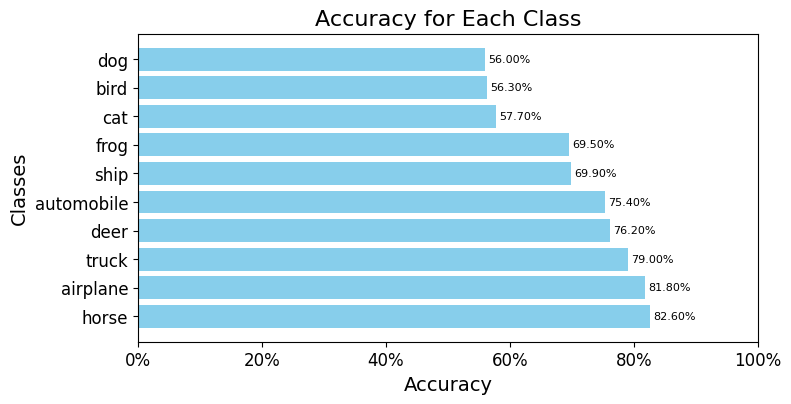

In [219]:
class_names = classes

# Calculating class accuracies
class_accuracies = {}
for i, label in enumerate(class_names):
    class_idx = np.array(all_labels) == i
    class_acc = np.mean(np.array(all_preds)[class_idx] == i)
    class_accuracies[label] = class_acc

# Sorting the accuracies and labels in descending order
sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)
sorted_labels, sorted_accs = zip(*sorted_accuracies)

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(sorted_labels, sorted_accs, color='skyblue')

# Adding data labels without digits next to the decimal point
for bar, acc in zip(bars, sorted_accs):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2, f'{acc * 100:.2f}%', va='center', fontsize=8)

ax.set_xlabel('Accuracy', fontsize=14)
ax.set_ylabel('Classes', fontsize=14)
ax.set_title('Accuracy for Each Class', fontsize=16)
ax.set_xlim(0, 1)  # Set x-axis limit to 0-100%
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Extracting Intermediate Representation & UMAP Plot

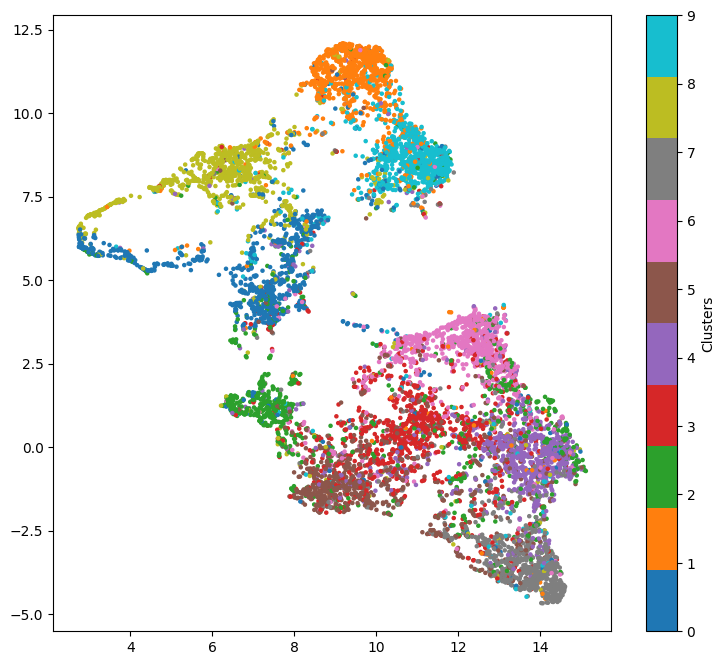

In [220]:
# Extract intermediate representations
class IntermediateModel(nn.Module):
    def __init__(self, model):
        super(IntermediateModel, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-1]
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

intermediate_model = IntermediateModel(model).to(device)
intermediate_representations = []

model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        features = intermediate_model(inputs)
        intermediate_representations.append(features)

intermediate_representations = torch.cat(intermediate_representations, dim=0)

# Reshape the tensor to (batch_size, num_features) for UMAP
intermediate_representations_reshaped = intermediate_representations.view(intermediate_representations.size(0), -1)

# Convert to numpy array
intermediate_representations_np = intermediate_representations_reshaped.cpu().numpy()

# Apply UMAP for dimensional reduction
umap_embeddings = umap.UMAP(n_neighbors=5, min_dist=0.03, metric='correlation').fit_transform(intermediate_representations_np)

# Visualize UMAP embeddings with distinct colors for each class
plt.figure(figsize=(9, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=testset.targets, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10), label='Clusters')
plt.show()

# Step 2

## Split dataset into Forget Data and Remaining Data

In [ ]:
trainset = torch.load('/content/trainset.pth')
testset = torch.load('/content/testset.pth')

In [ ]:
# index of ship class
ship_class_index = trainset.classes.index('ship')


#  Selecting onlu 3000 images randomly from the ship class
# ship_subset_indices = random.sample([i for i, (_, label) in enumerate(trainset) if label == ship_class_index], 3000)

# # Create a Subset dataset with the selected indices
# forget_dataset = torch.utils.data.Subset(trainset, ship_subset_indices)

# Split the dataset into "Forget" and "Remaining" datasets
forget_indices = [i for i, (_, label) in enumerate(trainset) if label == ship_class_index]
remaining_indices = [i for i in range(len(trainset)) if i not in forget_indices]

forget_dataset = torch.utils.data.Subset(trainset, forget_indices)
remaining_dataset = torch.utils.data.Subset(trainset, remaining_indices)

# Define the sizes for train and test sets for the "Forget" dataset
train_size = int(0.8 * len(forget_dataset))
test_size = len(forget_dataset) - train_size

# Split "Forget" dataset into train and test sets
forget_train_set, forget_test_set = random_split(forget_dataset, [train_size, test_size])

# Define the sizes for train and test sets for the "Remaining" dataset
train_size = int(0.8 * len(remaining_dataset))
test_size = len(remaining_dataset) - train_size

# Split "Remaining" dataset into train and test sets
remaining_train_set, remaining_test_set = random_split(remaining_dataset, [train_size, test_size])

In [ ]:
# sizes of the datasets
print(f"Forget Train Set Size: {len(forget_train_set)}")
print(f"Forget Test Set Size: {len(forget_test_set)}")
print(f"Remaining Train Set Size: {len(remaining_train_set)}")
print(f"Remaining Test Set Size: {len(remaining_test_set)}")

In [ ]:
# DataLoader for Forget Train Set
forget_train_loader = DataLoader(forget_train_set, batch_size=batch_size, shuffle=True)

# DataLoader for Forget Test Set
forget_test_loader = DataLoader(forget_test_set, batch_size=batch_size, shuffle=False)

# DataLoader for Remaining Train Set
remaining_train_loader = DataLoader(remaining_train_set, batch_size=batch_size, shuffle=True)

# DataLoader for Remaining Test Set
remaining_test_loader = DataLoader(remaining_test_set, batch_size=batch_size, shuffle=False)


## Training Retrained Model

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in remaining_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(remaining_train_loader)}")

In [ ]:
# Saving the retrained model
torch.save(model.state_dict(), 'retrained_model.pth')

In [ ]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in remaining_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy of Retrained Model on the test set: {accuracy * 100:.2f}%")

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

### Here we can see in the classification report of all classes except ship class

### Neighbouring method

The following code is base class, `AttackBase`, for adversarial attacks (Neighbouring Method). It includes methods for setting loss criteria, generating perturbations, normalizing data, and clamping perturbations.

In [ ]:
class AttackBase(object):
    def __init__(self, model=None, norm=False, discrete=True, device=None):
        self.model = model
        self.norm = norm
        # Normalization
        if self.norm:
            self.mean = (0.4914, 0.4822, 0.2265)
            self.std = (0.2023, 0.1994, 0.2010)
        self.discrete = discrete
        self.device = device or torch.device("cuda:0")
        self.loss(device=self.device)

    def loss(self, custom_loss=None, device=None):
        device = device or self.device
        self.criterion = custom_loss or nn.CrossEntropyLoss()
        self.criterion.to(device)

    def perturb(self, x):
        raise NotImplementedError

    def normalize(self, x):
        if self.norm:
            y = x.clone().to(x.device)
            y[:, 0, :, :] = (y[:, 0, :, :] - self.mean[0]) / self.std[0]
            y[:, 1, :, :] = (y[:, 1, :, :] - self.mean[1]) / self.std[1]
            y[:, 2, :, :] = (y[:, 2, :, :] - self.mean[2]) / self.std[2]
            return y
        return x

    def inverse_normalize(self, x):
        if self.norm:
            y = x.clone().to(x.device)
            y[:, 0, :, :] = y[:, 0, :, :] * self.std[0] + self.mean[0]
            y[:, 1, :, :] = y[:, 1, :, :] * self.std[1] + self.mean[1]
            y[:, 2, :, :] = y[:, 2, :, :] * self.std[2] + self.mean[2]
            return y
        return x

    def discretize(self, x):
        return torch.round(x * 255) / 255

    def clamper(self, x_adv, x_nat, bound=None, metric="inf", inverse_normalized=False):
        if not inverse_normalized:
            x_adv = self.inverse_normalize(x_adv)
            x_nat = self.inverse_normalize(x_nat)
        if metric == "inf":
            clamp_delta = torch.clamp(x_adv - x_nat, -bound, bound)
        else:
            clamp_delta = x_adv - x_nat
            for batch_index in range(clamp_delta.size(0)):
                image_delta = clamp_delta[batch_index]
                image_norm = image_delta.norm(p=metric, keepdim=False)
                if image_norm > bound:
                    clamp_delta[batch_index] /= image_norm
                    clamp_delta[batch_index] *= bound
        x_adv = x_nat + clamp_delta
        x_adv = torch.clamp(x_adv, 0., 1.)
        return self.normalize(self.discretize(x_adv)).clone().detach().requires_grad_(True)

## L-infinity Projected Gradient Descent
The `LinfPGD` is a subclass of Attackbase. It is the implementation of the L-infinity Projected Gradient Descent (PGD) adversarial attack. It extends the `AttackBase` class and includes parameters for attack configuration such as perturbation bound, step size, and number of iterations. The `perturb` method generates adversarial perturbations using PGD, considering options for random initialization and handling discretization and clamping of perturbations.

In [ ]:
class LinfPGD(AttackBase):
    def __init__(self, model=None, bound=None, step=None, iters=None, norm=False, random_start=False, discrete=True,
                 device=None, **kwargs):
        """
        Initialize the L-infinity PGD adversarial attack.

        Parameters:
            - model: Model to be attacked.
            - bound: Perturbation bound for the attack.
            - step: Size of each step in the attack.
            - iters: Number of iterations for the attack.
            - norm: Flag indicating whether normalization should be applied.
            - random_start: Flag indicating whether to start with a random perturbation.
            - discrete: Flag indicating whether perturbations should be discrete.
            - device: Device on which the attack should run.
        """
        super(LinfPGD, self).__init__(model, norm, discrete, device)
        self.bound = bound
        self.step = step
        self.iter = iters
        self.rand = random_start

    def perturb(self, x, y, target_y=None, model=None, bound=None, step=None, iters=None, x_nat=None, device=None,
                **kwargs):
        """
        Generate adversarial perturbations using L-infinity PGD attack.

        Parameters:
            - x: Input data.
            - y: True labels.
            - target_y: Target labels for targeted attacks.
            - model: model to be attacked.
            - bound: Perturbation bound for the attack.
            - step: Size of each step in the attack.
            - iters: Number of iterations for the attack.
            - x_nat: Natural input data (used if not provided during perturbation).
            - device: Device on which the attack should run.

        Returns:
            - x_adv: Adversarial perturbed data.
        """
        criterion = self.criterion
        model = model or self.model
        bound = bound or self.bound
        step = step or self.step
        iters = iters or self.iter
        device = device or self.device

        # Set the model gradients to zero
        model.zero_grad()

        # Normalize the natural input data if not provided
        if x_nat is None:
            x_nat = self.inverse_normalize(x.detach().clone().to(device))
        else:
            x_nat = self.inverse_normalize(x_nat.detach().clone().to(device))

        # Initialize the adversarial perturbation
        x_adv = x.detach().clone().requires_grad_(True).to(device)

        # Add random perturbation if specified
        if self.rand:
            rand_perturb_dist = distributions.uniform.Uniform(-bound, bound)
            rand_perturb = rand_perturb_dist.sample(sample_shape=x_adv.shape).to(device)
            x_adv = self.clamper(self.inverse_normalize(x_adv) + rand_perturb,
                                 self.inverse_normalize(x_nat), bound=bound, inverse_normalized=True)
            if self.discretize:
                x_adv = self.normalize(self.discretize(x_adv)).detach().clone().requires_grad_(True)
            else:
                x_adv = self.normalize(x_adv).detach().clone().requires_grad_(True)

        # PGD iteration
        for i in range(iters):
            adv_pred = model(x_adv)
            ori_pred = model(x)
            delta_pred = adv_pred - ori_pred

            # Adjust predictions for negative log-likelihood loss
            if criterion.__class__.__name__ == "NLLLoss":
                delta_pred = F.log_softmax(delta_pred, dim=-1)

            # Calculate loss
            if target_y is not None:
                loss = - criterion(delta_pred, target_y)
            else:
                loss = criterion(adv_pred, y)

            # Backward pass and gradient calculation
            loss.backward()

            # Update the adversarial perturbation based on gradient sign
            grad_sign = x_adv.grad.data.detach().sign()
            x_adv = self.inverse_normalize(x_adv) + grad_sign * step
            x_adv = self.clamper(x_adv, x_nat, bound=bound, inverse_normalized=True)

            # Reset model gradients
            model.zero_grad()

        return x_adv.detach().to(device)


inf_generator==> yield adv samples

In [ ]:
def inf_generator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

## Boundry Shrink (Unlearn Model)
This code implements "Boundary Shrink" method. It fine-tunes a pre-trained (original) model with the a neighbor-searching approach to identify the nearest but incorrect class labels for forgetting samples. This precise shift of the decision boundary is achieved through targeted reassignment of labels, leading to a reduction in the model's performance on the specified forgetting class. The success of the attack is evaluated, and the unlearned model is saved.

In [ ]:
def boundary_shrink(ori_model, train_forget_loader, dt, dv, test_loader, device, evaluate,
                    bound=0.1, step=8 / 255, iter=5, poison_epoch=10, forget_class=0, path='./',
                    extra_exp=None, lambda_=0.7, bias=-0.5, slope=5.0):
  # Initialize variables and models
    start = time.time()
    norm = True
    random_start = True

    test_model = copy.deepcopy(ori_model).to(device)
    unlearn_model = copy.deepcopy(ori_model).to(device)
    start_time = time.time()

    # Set up adversarial attack
    adv = LinfPGD(test_model, bound, step, iter, norm, random_start, device)
    forget_data_gen = inf_generator(train_forget_loader)
    batches_per_epoch = len(train_forget_loader)
    # Define loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(unlearn_model.parameters(), lr=0.00001, momentum=0.9)

    num_hits = 0
    num_sum = 0
    nearest_label = []

    # Poisoning and unlearning loop

    for itr in tqdm.tqdm(range(poison_epoch * batches_per_epoch)):

        x, y = forget_data_gen.__next__()
        x = x.to(device)
        y = y.to(device)
        test_model.eval()

        # Generate adversarial examples
        x_adv = adv.perturb(x, y, target_y=None, model=test_model, device=device)
        adv_logits = test_model(x_adv)
        pred_label = torch.argmax(adv_logits, dim=1)

        # Save nearest labels after poisoning phase
        if itr >= (poison_epoch - 1) * batches_per_epoch:
            nearest_label.append(pred_label.tolist())
        num_hits += (y != pred_label).float().sum()
        num_sum += y.shape[0]

        # Unlearn by fine-tuning
        unlearn_model.train()
        unlearn_model.zero_grad()
        optimizer.zero_grad()

        ori_logits = unlearn_model(x)
        ori_loss = criterion(ori_logits, pred_label)


        loss = ori_loss
        loss.backward()
        optimizer.step()

    print('attack success ratio:', (num_hits / num_sum).float())

    print('boundary shrink time:', (time.time() - start_time))

    torch.save(unlearn_model, 'boundary_shrink_unlearn_model.pth')

In [ ]:
# Calling boundry_shrink function

bound = 0.1
step = 2 / 255
iter = 10
poison_epoch = 10
forget_class = 8
path = '/content'
lambda_ = 0.7
bias = -0.5
slope = 5.0

boundary_shrink(
    ori_model=ori_model,
    train_forget_loader=forget_train_loader,
    dt=trainset,
    dv=testset,
    test_loader=test_loader,
    device=device,
    evaluate=eval,
    bound=bound,
    step=step,
    iter=iter,
    poison_epoch=poison_epoch,
    forget_class=forget_class,
    path=path,
    lambda_=lambda_,
    bias=bias,
    slope=slope
)


In [ ]:
unlearn_model = torch.load('boundary_shrink_unlearn_model.pth').to(device)

## Unlearn Model Evaluation

In [ ]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on Unlearn Model on test set: {accuracy * 100:.2f}%")

In [225]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1000
           1       0.89      0.75      0.81      1000
           2       0.74      0.56      0.64      1000
           3       0.54      0.58      0.56      1000
           4       0.53      0.76      0.62      1000
           5       0.56      0.56      0.56      1000
           6       0.84      0.69      0.76      1000
           7       0.71      0.83      0.77      1000
           8       0.90      0.70      0.78      1000
           9       0.79      0.79      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.71     10000
weighted avg       0.72      0.70      0.71     10000



## From the above code, we can see the accuracy of ship class is 0, which mean our unlearn model has forgotten the forget class.

In [ ]:
class_names = classes

# Calculate class accuracies
class_accuracies = {}
for i, label in enumerate(class_names):
    class_idx = np.array(all_labels) == i
    class_acc = np.mean(np.array(all_preds)[class_idx] == i)
    class_accuracies[label] = class_acc

# Sort the accuracies and labels in descending order
sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)
sorted_labels, sorted_accs = zip(*sorted_accuracies)

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(sorted_labels, sorted_accs, color='skyblue')

# Adding data labels without digits next to the decimal point
for bar, acc in zip(bars, sorted_accs):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2, f'{acc * 100:.2f}%', va='center', fontsize=8)

ax.set_xlabel('Accuracy', fontsize=14)
ax.set_ylabel('Classes', fontsize=14)
ax.set_title('Accuracy for Each Class', fontsize=16)
ax.set_xlim(0, 1)  # Set x-axis limit to 0-100%
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))  # Format x-axis as percentage
ax.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size
plt.show()

In [ ]:
# Extract intermediate representations
class IntermediateModel(nn.Module):
    def __init__(self, model):
        super(IntermediateModel, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-1]
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

intermediate_model = IntermediateModel(model).to(device)
intermediate_representations = []

model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        features = intermediate_model(inputs)
        intermediate_representations.append(features)

intermediate_representations = torch.cat(intermediate_representations, dim=0)

# Reshape the tensor to (batch_size, num_features) for UMAP
intermediate_representations_reshaped = intermediate_representations.view(intermediate_representations.size(0), -1)

# Convert to numpy array
intermediate_representations_np = intermediate_representations_reshaped.cpu().numpy()

# Apply UMAP for dimensional reduction
umap_embeddings = umap.UMAP(n_neighbors=5, min_dist=0.03, metric='correlation').fit_transform(intermediate_representations_np)

# Visualize UMAP embeddings with distinct colors for each class
plt.figure(figsize=(9, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=testset.targets, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10), label='Clusters')
plt.show()

In [ ]:
# Forget accuracy
model.eval()  # Set the model to evaluation mode

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in forget_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on the Forget Test Set: {accuracy * 100:.2f}%")

In [ ]:
# Remaining accuracy
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in remaining_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on the Remaining Test Set: {accuracy * 100:.2f}%")

## After adjusting parameters of unlearn model (Step 3)

In [ ]:
# Set your parameters
bound = 0.1
step = 8 / 255
iter = 15
poison_epoch = 20
forget_class = 8
path = '/content'
lambda_ = 0.7
bias = -0.5
slope = 5.0

# Call the boundary_shrink function
boundary_shrink(
    ori_model=ori_model,
    train_forget_loader=forget_train_loader,
    dt=trainset,
    dv=testset,
    test_loader=test_loader,
    device=device,
    evaluate=eval,
    bound=bound,
    step=step,
    iter=iter,
    poison_epoch=poison_epoch,
    forget_class=forget_class,
    path=path,
    lambda_=lambda_,
    bias=bias,
    slope=slope
)


In [ ]:
unlearn_model = torch.load('boundary_shrink_unlearn_model.pth').to(device)

In [ ]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

In [ ]:
# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds))

In [ ]:
class_names = classes

# Calculate class accuracies
class_accuracies = {}
for i, label in enumerate(class_names):
    class_idx = np.array(all_labels) == i
    class_acc = np.mean(np.array(all_preds)[class_idx] == i)
    class_accuracies[label] = class_acc

# Sort the accuracies and labels in descending order
sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)
sorted_labels, sorted_accs = zip(*sorted_accuracies)

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(sorted_labels, sorted_accs, color='skyblue')

# Adding data labels without digits next to the decimal point
for bar, acc in zip(bars, sorted_accs):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2, f'{acc * 100:.2f}%', va='center', fontsize=8)

ax.set_xlabel('Accuracy', fontsize=14)
ax.set_ylabel('Classes', fontsize=14)
ax.set_title('Accuracy for Each Class', fontsize=16)
ax.set_xlim(0, 1)  # Set x-axis limit to 0-100%
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Extracting IR and Plotting

In [ ]:
# Extract intermediate representations
class IntermediateModel(nn.Module):
    def __init__(self, model):
        super(IntermediateModel, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-1]
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

intermediate_model = IntermediateModel(model).to(device)
intermediate_representations = []

model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        features = intermediate_model(inputs)
        intermediate_representations.append(features)

intermediate_representations = torch.cat(intermediate_representations, dim=0)

# Reshape the tensor to (batch_size, num_features) for UMAP
intermediate_representations_reshaped = intermediate_representations.view(intermediate_representations.size(0), -1)

# Convert to numpy array
intermediate_representations_np = intermediate_representations_reshaped.cpu().numpy()

# Apply UMAP for dimensional reduction
umap_embeddings = umap.UMAP(n_neighbors=5, min_dist=0.03, metric='correlation').fit_transform(intermediate_representations_np)

# Visualize UMAP embeddings with distinct colors for each class
plt.figure(figsize=(9, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=testset.targets, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10), label='Clusters')
plt.show()

In [ ]:
# Forget accuracy
model.eval()  # Set the model to evaluation mode

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in forget_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on the Forget Test Set: {accuracy * 100:.2f}%")

In [ ]:
# Remain accuracy
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in remaining_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on the Remaining Test Set: {accuracy * 100:.2f}%")

# Comparison
Our unlearn model exhibits the capability to forget labels associated with the forget class.
In Step 2, the accuracy for the forgetting class was _______, while on the remaining classes_________,
it achieved _______. In Step 3, after adjusting the parameters, a slight enhancement was observed in the boundary shrinking.and the accuracy for the forgetting class was _______, while on the remaining classes_________,